In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 32)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 32)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7241 - acc: 0.0946
Epoch 00001: val_loss improved from inf to 2.62484, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/001-2.6248.hdf5
36805/36805 [==============================] - 25s 687us/sample - loss: 2.7241 - acc: 0.0946 - val_loss: 2.6248 - val_acc: 0.2020
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5582 - acc: 0.1571
Epoch 00002: val_loss improved from 2.62484 to 2.37893, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/002-2.3789.hdf5
36805/36805 [==============================] - 23s 613us/sample - loss: 2.5580 - acc: 0.1573 - val_loss: 2.3789 - val_acc: 0.2826
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 21/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6744 - acc: 0.4385
Epoch 00021: val_loss improved from 1.40201 to 1.37769, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/021-1.3777.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 1.6744 - acc: 0.4385 - val_loss: 1.3777 - val_acc: 0.5877
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6582 - acc: 0.4497
Epoch 00022: val_loss improved from 1.37769 to 1.35210, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/022-1.3521.hdf5
36805/36805 [==============================] - 22s 606us/sample - loss: 1.6583 - acc: 0.4497 - val_loss: 1.3521 - val_acc: 0.5898
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6380 - acc: 0.4552
Epoch 00023: val_loss improved from 1.35210 to 1.34376, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_ch

Epoch 43/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4284 - acc: 0.5324
Epoch 00043: val_loss improved from 1.10279 to 1.09408, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/043-1.0941.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 1.4283 - acc: 0.5324 - val_loss: 1.0941 - val_acc: 0.6699
Epoch 44/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4329 - acc: 0.5322
Epoch 00044: val_loss improved from 1.09408 to 1.08849, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/044-1.0885.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 1.4332 - acc: 0.5322 - val_loss: 1.0885 - val_acc: 0.6711
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4194 - acc: 0.5358
Epoch 00045: val_loss improved from 1.08849 to 1.07681, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_ch

36800/36805 [============================>.] - ETA: 0s - loss: 1.3315 - acc: 0.5675
Epoch 00066: val_loss improved from 0.97401 to 0.97339, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/066-0.9734.hdf5
36805/36805 [==============================] - 22s 609us/sample - loss: 1.3314 - acc: 0.5675 - val_loss: 0.9734 - val_acc: 0.7088
Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3203 - acc: 0.5702
Epoch 00067: val_loss improved from 0.97339 to 0.96545, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/067-0.9654.hdf5
36805/36805 [==============================] - 22s 609us/sample - loss: 1.3203 - acc: 0.5702 - val_loss: 0.9654 - val_acc: 0.7102
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3263 - acc: 0.5686
Epoch 00068: val_loss did not improve from 0.96545
36805/36805 [==============================] - 22s 606us/sample - loss: 1.3263 - acc: 0.5685 - 

Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2671 - acc: 0.5876
Epoch 00091: val_loss did not improve from 0.91494
36805/36805 [==============================] - 22s 609us/sample - loss: 1.2673 - acc: 0.5875 - val_loss: 0.9253 - val_acc: 0.7270
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2713 - acc: 0.5876
Epoch 00092: val_loss improved from 0.91494 to 0.91052, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/092-0.9105.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 1.2714 - acc: 0.5875 - val_loss: 0.9105 - val_acc: 0.7303
Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2712 - acc: 0.5871
Epoch 00093: val_loss improved from 0.91052 to 0.90419, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/093-0.9042.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 1.2713 - a

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2348 - acc: 0.5997
Epoch 00116: val_loss improved from 0.87319 to 0.87161, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/116-0.8716.hdf5
36805/36805 [==============================] - 22s 607us/sample - loss: 1.2347 - acc: 0.5997 - val_loss: 0.8716 - val_acc: 0.7438
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2309 - acc: 0.6003
Epoch 00117: val_loss did not improve from 0.87161
36805/36805 [==============================] - 23s 621us/sample - loss: 1.2310 - acc: 0.6002 - val_loss: 0.8757 - val_acc: 0.7412
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2364 - acc: 0.5999
Epoch 00118: val_loss did not improve from 0.87161
36805/36805 [==============================] - 22s 607us/sample - loss: 1.2363 - acc: 0.5999 - val_loss: 0.8741 - val_acc: 0.7428
Epoch 119/500
36800/36805 [============================>

Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2009 - acc: 0.6127
Epoch 00143: val_loss did not improve from 0.83698
36805/36805 [==============================] - 22s 606us/sample - loss: 1.2008 - acc: 0.6128 - val_loss: 0.8396 - val_acc: 0.7531
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2023 - acc: 0.6121
Epoch 00144: val_loss did not improve from 0.83698
36805/36805 [==============================] - 22s 607us/sample - loss: 1.2023 - acc: 0.6121 - val_loss: 0.8461 - val_acc: 0.7522
Epoch 145/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2102 - acc: 0.6079
Epoch 00145: val_loss did not improve from 0.83698
36805/36805 [==============================] - 22s 606us/sample - loss: 1.2104 - acc: 0.6079 - val_loss: 0.8619 - val_acc: 0.7494
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2131 - acc: 0.6086
Epoch 00146: val_loss did not improve from 0.83698
36805/36805 [=

Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1830 - acc: 0.6168
Epoch 00169: val_loss did not improve from 0.81746
36805/36805 [==============================] - 22s 608us/sample - loss: 1.1829 - acc: 0.6169 - val_loss: 0.8175 - val_acc: 0.7605
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1923 - acc: 0.6158
Epoch 00170: val_loss did not improve from 0.81746
36805/36805 [==============================] - 23s 621us/sample - loss: 1.1925 - acc: 0.6157 - val_loss: 0.8257 - val_acc: 0.7543
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1895 - acc: 0.6162
Epoch 00171: val_loss did not improve from 0.81746
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1895 - acc: 0.6162 - val_loss: 0.8299 - val_acc: 0.7517
Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1861 - acc: 0.6135
Epoch 00172: val_loss did not improve from 0.81746
36805/36805 [=

Epoch 197/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1699 - acc: 0.6193
Epoch 00197: val_loss did not improve from 0.80079
36805/36805 [==============================] - 22s 605us/sample - loss: 1.1697 - acc: 0.6193 - val_loss: 0.8097 - val_acc: 0.7636
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1638 - acc: 0.6267
Epoch 00198: val_loss did not improve from 0.80079
36805/36805 [==============================] - 22s 608us/sample - loss: 1.1639 - acc: 0.6267 - val_loss: 0.8083 - val_acc: 0.7612
Epoch 199/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1624 - acc: 0.6251
Epoch 00199: val_loss did not improve from 0.80079
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1620 - acc: 0.6251 - val_loss: 0.8081 - val_acc: 0.7652
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1589 - acc: 0.6237
Epoch 00200: val_loss did not improve from 0.80079
36805/36805 [=

Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1529 - acc: 0.6295
Epoch 00224: val_loss did not improve from 0.78305
36805/36805 [==============================] - 23s 621us/sample - loss: 1.1530 - acc: 0.6295 - val_loss: 0.7885 - val_acc: 0.7654
Epoch 225/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1491 - acc: 0.6280
Epoch 00225: val_loss did not improve from 0.78305
36805/36805 [==============================] - 22s 608us/sample - loss: 1.1491 - acc: 0.6280 - val_loss: 0.8041 - val_acc: 0.7619
Epoch 226/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1449 - acc: 0.6323
Epoch 00226: val_loss did not improve from 0.78305
36805/36805 [==============================] - 22s 608us/sample - loss: 1.1450 - acc: 0.6322 - val_loss: 0.7840 - val_acc: 0.7673
Epoch 227/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1505 - acc: 0.6299
Epoch 00227: val_loss did not improve from 0.78305
36805/36805 [=

Epoch 252/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1301 - acc: 0.6351
Epoch 00252: val_loss improved from 0.77213 to 0.77197, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/252-0.7720.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 1.1301 - acc: 0.6350 - val_loss: 0.7720 - val_acc: 0.7734
Epoch 253/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1419 - acc: 0.6299
Epoch 00253: val_loss did not improve from 0.77197
36805/36805 [==============================] - 22s 606us/sample - loss: 1.1420 - acc: 0.6299 - val_loss: 0.7806 - val_acc: 0.7664
Epoch 254/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1332 - acc: 0.6355
Epoch 00254: val_loss did not improve from 0.77197
36805/36805 [==============================] - 22s 606us/sample - loss: 1.1332 - acc: 0.6355 - val_loss: 0.7747 - val_acc: 0.7710
Epoch 255/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 1.1192 - acc: 0.6396
Epoch 00279: val_loss did not improve from 0.75638
36805/36805 [==============================] - 23s 621us/sample - loss: 1.1192 - acc: 0.6396 - val_loss: 0.7688 - val_acc: 0.7696
Epoch 280/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1170 - acc: 0.6365
Epoch 00280: val_loss did not improve from 0.75638
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1170 - acc: 0.6366 - val_loss: 0.7646 - val_acc: 0.7675
Epoch 281/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1193 - acc: 0.6390
Epoch 00281: val_loss did not improve from 0.75638
36805/36805 [==============================] - 22s 605us/sample - loss: 1.1196 - acc: 0.6388 - val_loss: 0.7753 - val_acc: 0.7706
Epoch 282/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1239 - acc: 0.6386
Epoch 00282: val_loss did not improve from 0.75638
36805/36805 [===============

Epoch 307/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1131 - acc: 0.6402
Epoch 00307: val_loss did not improve from 0.75214
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1132 - acc: 0.6402 - val_loss: 0.7577 - val_acc: 0.7738
Epoch 308/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1140 - acc: 0.6404
Epoch 00308: val_loss did not improve from 0.75214
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1139 - acc: 0.6404 - val_loss: 0.7593 - val_acc: 0.7706
Epoch 309/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1061 - acc: 0.6445
Epoch 00309: val_loss did not improve from 0.75214
36805/36805 [==============================] - 23s 618us/sample - loss: 1.1062 - acc: 0.6445 - val_loss: 0.7524 - val_acc: 0.7785
Epoch 310/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1116 - acc: 0.6436
Epoch 00310: val_loss did not improve from 0.75214
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 1.0981 - acc: 0.6441
Epoch 00335: val_loss improved from 0.74542 to 0.74456, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv_checkpoint/335-0.7446.hdf5
36805/36805 [==============================] - 22s 607us/sample - loss: 1.0982 - acc: 0.6440 - val_loss: 0.7446 - val_acc: 0.7775
Epoch 336/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1009 - acc: 0.6476
Epoch 00336: val_loss did not improve from 0.74456
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1008 - acc: 0.6475 - val_loss: 0.7566 - val_acc: 0.7754
Epoch 337/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1032 - acc: 0.6420
Epoch 00337: val_loss did not improve from 0.74456
36805/36805 [==============================] - 22s 607us/sample - loss: 1.1035 - acc: 0.6419 - val_loss: 0.7499 - val_acc: 0.7782
Epoch 338/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 363/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0890 - acc: 0.6514
Epoch 00363: val_loss did not improve from 0.73118
36805/36805 [==============================] - 23s 622us/sample - loss: 1.0890 - acc: 0.6514 - val_loss: 0.7441 - val_acc: 0.7745
Epoch 364/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0899 - acc: 0.6482
Epoch 00364: val_loss did not improve from 0.73118
36805/36805 [==============================] - 22s 609us/sample - loss: 1.0898 - acc: 0.6483 - val_loss: 0.7363 - val_acc: 0.7801
Epoch 365/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0827 - acc: 0.6504
Epoch 00365: val_loss did not improve from 0.73118
36805/36805 [==============================] - 22s 609us/sample - loss: 1.0826 - acc: 0.6504 - val_loss: 0.7375 - val_acc: 0.7806
Epoch 366/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0857 - acc: 0.6489
Epoch 00366: val_loss did not improve from 0.73118
36805/36805 [=

Epoch 393/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0848 - acc: 0.6476
Epoch 00393: val_loss did not improve from 0.73118
36805/36805 [==============================] - 22s 609us/sample - loss: 1.0849 - acc: 0.6476 - val_loss: 0.7424 - val_acc: 0.7827
Epoch 394/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0755 - acc: 0.6518
Epoch 00394: val_loss did not improve from 0.73118
36805/36805 [==============================] - 23s 619us/sample - loss: 1.0755 - acc: 0.6519 - val_loss: 0.7354 - val_acc: 0.7829
Epoch 395/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0832 - acc: 0.6504
Epoch 00395: val_loss did not improve from 0.73118
36805/36805 [==============================] - 22s 609us/sample - loss: 1.0832 - acc: 0.6504 - val_loss: 0.7381 - val_acc: 0.7834
Epoch 396/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0757 - acc: 0.6528
Epoch 00396: val_loss did not improve from 0.73118
36805/36805 [=

Epoch 422/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0725 - acc: 0.6555
Epoch 00422: val_loss did not improve from 0.72380
36805/36805 [==============================] - 23s 612us/sample - loss: 1.0726 - acc: 0.6554 - val_loss: 0.7360 - val_acc: 0.7836
Epoch 423/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0802 - acc: 0.6516
Epoch 00423: val_loss did not improve from 0.72380
36805/36805 [==============================] - 22s 609us/sample - loss: 1.0802 - acc: 0.6516 - val_loss: 0.7269 - val_acc: 0.7838
Epoch 424/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0677 - acc: 0.6552
Epoch 00424: val_loss did not improve from 0.72380
36805/36805 [==============================] - 22s 597us/sample - loss: 1.0681 - acc: 0.6552 - val_loss: 0.7340 - val_acc: 0.7785
Epoch 425/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0728 - acc: 0.6523
Epoch 00425: val_loss did not improve from 0.72380
36805/36805 [=

Epoch 451/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0627 - acc: 0.6565
Epoch 00451: val_loss did not improve from 0.72236
36805/36805 [==============================] - 22s 610us/sample - loss: 1.0627 - acc: 0.6565 - val_loss: 0.7299 - val_acc: 0.7824
Epoch 452/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0666 - acc: 0.6557
Epoch 00452: val_loss did not improve from 0.72236
36805/36805 [==============================] - 22s 610us/sample - loss: 1.0660 - acc: 0.6558 - val_loss: 0.7320 - val_acc: 0.7878
Epoch 453/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0602 - acc: 0.6583
Epoch 00453: val_loss did not improve from 0.72236
36805/36805 [==============================] - 22s 611us/sample - loss: 1.0599 - acc: 0.6585 - val_loss: 0.7291 - val_acc: 0.7813
Epoch 454/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0700 - acc: 0.6544
Epoch 00454: val_loss did not improve from 0.72236
36805/36805 [=

Epoch 480/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0571 - acc: 0.6577
Epoch 00480: val_loss did not improve from 0.72062
36805/36805 [==============================] - 22s 607us/sample - loss: 1.0570 - acc: 0.6577 - val_loss: 0.7333 - val_acc: 0.7878
Epoch 481/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0585 - acc: 0.6557
Epoch 00481: val_loss did not improve from 0.72062
36805/36805 [==============================] - 23s 615us/sample - loss: 1.0585 - acc: 0.6557 - val_loss: 0.7249 - val_acc: 0.7873
Epoch 482/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0597 - acc: 0.6580
Epoch 00482: val_loss did not improve from 0.72062
36805/36805 [==============================] - 22s 611us/sample - loss: 1.0600 - acc: 0.6579 - val_loss: 0.7258 - val_acc: 0.7845
Epoch 483/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0595 - acc: 0.6565
Epoch 00483: val_loss did not improve from 0.72062
36805/36805 [=

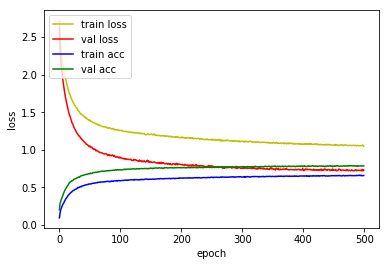

4815/4815 [==============================] - 2s 352us/sample - loss: 0.7881 - acc: 0.7618
Loss: 0.7881466261322996 Accuracy: 0.7617861

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6827 - acc: 0.1090
Epoch 00001: val_loss improved from inf to 2.51702, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/001-2.5170.hdf5
36805/36805 [==============================] - 24s 649us/sample - loss: 2.6827 - acc: 0.1091 - val_loss: 2.5170 - val_acc: 0.2266
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4341 - acc: 0.1878
Epoch 00002: val_loss improved from 2.51702 to 2.21746, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/002-2.2175.hdf5
36805/36805 [==============================] - 22s 604us/sample - loss: 2.4342 - acc: 0.1877 - val_loss: 2.2175 - val_acc: 0.3208
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4129 - acc: 0.5324
Epoch 00022: val_loss improved from 1.12773 to 1.11020, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/022-1.1102.hdf5
36805/36805 [==============================] - 22s 594us/sample - loss: 1.4129 - acc: 0.5324 - val_loss: 1.1102 - val_acc: 0.6667
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3940 - acc: 0.5396
Epoch 00023: val_loss improved from 1.11020 to 1.08533, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/023-1.0853.hdf5
36805/36805 [==============================] - 22s 597us/sample - loss: 1.3940 - acc: 0.5396 - val_loss: 1.0853 - val_acc: 0.6690
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3733 - acc: 0.5463
Epoch 00024: val_loss improved from 1.08533 to 1.06054, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_ch

36736/36805 [============================>.] - ETA: 0s - loss: 1.1786 - acc: 0.6185
Epoch 00044: val_loss improved from 0.86349 to 0.85803, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/044-0.8580.hdf5
36805/36805 [==============================] - 22s 600us/sample - loss: 1.1782 - acc: 0.6186 - val_loss: 0.8580 - val_acc: 0.7428
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1646 - acc: 0.6189
Epoch 00045: val_loss did not improve from 0.85803
36805/36805 [==============================] - 22s 603us/sample - loss: 1.1645 - acc: 0.6189 - val_loss: 0.8719 - val_acc: 0.7405
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1640 - acc: 0.6224
Epoch 00046: val_loss improved from 0.85803 to 0.85382, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/046-0.8538.hdf5
36805/36805 [==============================] - 22s 604us/sample - loss: 1.1640 - acc: 0.6224 - 

Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0765 - acc: 0.6510
Epoch 00067: val_loss did not improve from 0.76186
36805/36805 [==============================] - 22s 603us/sample - loss: 1.0766 - acc: 0.6509 - val_loss: 0.7725 - val_acc: 0.7622
Epoch 68/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0697 - acc: 0.6572
Epoch 00068: val_loss did not improve from 0.76186
36805/36805 [==============================] - 23s 618us/sample - loss: 1.0699 - acc: 0.6572 - val_loss: 0.7807 - val_acc: 0.7624
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0729 - acc: 0.6568
Epoch 00069: val_loss did not improve from 0.76186
36805/36805 [==============================] - 22s 599us/sample - loss: 1.0729 - acc: 0.6568 - val_loss: 0.7652 - val_acc: 0.7703
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0709 - acc: 0.6542
Epoch 00070: val_loss improved from 0.76186 to 0.76044, saving model 

36800/36805 [============================>.] - ETA: 0s - loss: 1.0151 - acc: 0.6716
Epoch 00092: val_loss did not improve from 0.70226
36805/36805 [==============================] - 22s 608us/sample - loss: 1.0151 - acc: 0.6716 - val_loss: 0.7190 - val_acc: 0.7822
Epoch 93/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0183 - acc: 0.6728
Epoch 00093: val_loss improved from 0.70226 to 0.69708, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/093-0.6971.hdf5
36805/36805 [==============================] - 23s 611us/sample - loss: 1.0186 - acc: 0.6728 - val_loss: 0.6971 - val_acc: 0.7813
Epoch 94/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0098 - acc: 0.6771
Epoch 00094: val_loss did not improve from 0.69708
36805/36805 [==============================] - 22s 605us/sample - loss: 1.0099 - acc: 0.6771 - val_loss: 0.7008 - val_acc: 0.7890
Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9792 - acc: 0.6868
Epoch 00118: val_loss did not improve from 0.65638
36805/36805 [==============================] - 23s 613us/sample - loss: 0.9792 - acc: 0.6868 - val_loss: 0.6624 - val_acc: 0.7978
Epoch 119/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9761 - acc: 0.6899
Epoch 00119: val_loss did not improve from 0.65638
36805/36805 [==============================] - 23s 619us/sample - loss: 0.9758 - acc: 0.6899 - val_loss: 0.6597 - val_acc: 0.7992
Epoch 120/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9738 - acc: 0.6888
Epoch 00120: val_loss did not improve from 0.65638
36805/36805 [==============================] - 23s 614us/sample - loss: 0.9743 - acc: 0.6887 - val_loss: 0.6564 - val_acc: 0.8022
Epoch 121/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9641 - acc: 0.6905
Epoch 00121: val_loss did not improve from 0.65638
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.9412 - acc: 0.6988
Epoch 00144: val_loss did not improve from 0.62849
36805/36805 [==============================] - 22s 604us/sample - loss: 0.9413 - acc: 0.6988 - val_loss: 0.6476 - val_acc: 0.8048
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9416 - acc: 0.7011
Epoch 00145: val_loss did not improve from 0.62849
36805/36805 [==============================] - 22s 608us/sample - loss: 0.9415 - acc: 0.7012 - val_loss: 0.6296 - val_acc: 0.8081
Epoch 146/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9414 - acc: 0.7013
Epoch 00146: val_loss did not improve from 0.62849
36805/36805 [==============================] - 23s 613us/sample - loss: 0.9419 - acc: 0.7013 - val_loss: 0.6365 - val_acc: 0.8099
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9397 - acc: 0.7002
Epoch 00147: val_loss improved from 0.62849 to 0.62843, saving model to model/c

Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9160 - acc: 0.7081
Epoch 00171: val_loss did not improve from 0.60547
36805/36805 [==============================] - 23s 617us/sample - loss: 0.9160 - acc: 0.7081 - val_loss: 0.6060 - val_acc: 0.8202
Epoch 172/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9122 - acc: 0.7063
Epoch 00172: val_loss improved from 0.60547 to 0.60468, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/172-0.6047.hdf5
36805/36805 [==============================] - 23s 632us/sample - loss: 0.9121 - acc: 0.7063 - val_loss: 0.6047 - val_acc: 0.8164
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9149 - acc: 0.7109
Epoch 00173: val_loss improved from 0.60468 to 0.60320, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/173-0.6032.hdf5
36805/36805 [==============================] - 22s 603us/sample - loss: 0.9148 

36800/36805 [============================>.] - ETA: 0s - loss: 0.8897 - acc: 0.7182
Epoch 00197: val_loss improved from 0.58416 to 0.57869, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/197-0.5787.hdf5
36805/36805 [==============================] - 22s 604us/sample - loss: 0.8897 - acc: 0.7182 - val_loss: 0.5787 - val_acc: 0.8258
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8916 - acc: 0.7196
Epoch 00198: val_loss did not improve from 0.57869
36805/36805 [==============================] - 23s 612us/sample - loss: 0.8916 - acc: 0.7196 - val_loss: 0.5883 - val_acc: 0.8283
Epoch 199/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8874 - acc: 0.7155
Epoch 00199: val_loss did not improve from 0.57869
36805/36805 [==============================] - 22s 609us/sample - loss: 0.8873 - acc: 0.7154 - val_loss: 0.5949 - val_acc: 0.8197
Epoch 200/500
36736/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.8721 - acc: 0.7214
Epoch 00224: val_loss improved from 0.56572 to 0.56570, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/224-0.5657.hdf5
36805/36805 [==============================] - 23s 613us/sample - loss: 0.8721 - acc: 0.7214 - val_loss: 0.5657 - val_acc: 0.8323
Epoch 225/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8704 - acc: 0.7235
Epoch 00225: val_loss did not improve from 0.56570
36805/36805 [==============================] - 22s 607us/sample - loss: 0.8704 - acc: 0.7235 - val_loss: 0.5752 - val_acc: 0.8295
Epoch 226/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8688 - acc: 0.7215
Epoch 00226: val_loss did not improve from 0.56570
36805/36805 [==============================] - 23s 612us/sample - loss: 0.8687 - acc: 0.7216 - val_loss: 0.5720 - val_acc: 0.8334
Epoch 227/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.8501 - acc: 0.7284
Epoch 00251: val_loss did not improve from 0.54978
36805/36805 [==============================] - 22s 611us/sample - loss: 0.8501 - acc: 0.7284 - val_loss: 0.5511 - val_acc: 0.8372
Epoch 252/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8527 - acc: 0.7271
Epoch 00252: val_loss did not improve from 0.54978
36805/36805 [==============================] - 22s 610us/sample - loss: 0.8525 - acc: 0.7272 - val_loss: 0.5566 - val_acc: 0.8318
Epoch 253/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8464 - acc: 0.7286
Epoch 00253: val_loss improved from 0.54978 to 0.54883, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_4_conv_checkpoint/253-0.5488.hdf5
36805/36805 [==============================] - 22s 608us/sample - loss: 0.8463 - acc: 0.7286 - val_loss: 0.5488 - val_acc: 0.8360
Epoch 254/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 278/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8329 - acc: 0.7325
Epoch 00278: val_loss did not improve from 0.53565
36805/36805 [==============================] - 22s 608us/sample - loss: 0.8329 - acc: 0.7325 - val_loss: 0.5443 - val_acc: 0.8379
Epoch 279/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8288 - acc: 0.7357
Epoch 00279: val_loss did not improve from 0.53565
36805/36805 [==============================] - 23s 617us/sample - loss: 0.8288 - acc: 0.7357 - val_loss: 0.5431 - val_acc: 0.8423
Epoch 280/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8401 - acc: 0.7324
Epoch 00280: val_loss did not improve from 0.53565
36805/36805 [==============================] - 22s 589us/sample - loss: 0.8400 - acc: 0.7324 - val_loss: 0.5455 - val_acc: 0.8358
Epoch 281/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8307 - acc: 0.7340
Epoch 00281: val_loss did not improve from 0.53565
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.8157 - acc: 0.7395
Epoch 00305: val_loss did not improve from 0.52298
36805/36805 [==============================] - 22s 606us/sample - loss: 0.8157 - acc: 0.7395 - val_loss: 0.5291 - val_acc: 0.8444
Epoch 306/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8169 - acc: 0.7376
Epoch 00306: val_loss did not improve from 0.52298
36805/36805 [==============================] - 23s 614us/sample - loss: 0.8166 - acc: 0.7377 - val_loss: 0.5307 - val_acc: 0.8435
Epoch 307/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8089 - acc: 0.7425
Epoch 00307: val_loss did not improve from 0.52298
36805/36805 [==============================] - 23s 613us/sample - loss: 0.8090 - acc: 0.7425 - val_loss: 0.5266 - val_acc: 0.8446
Epoch 308/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8135 - acc: 0.7403
Epoch 00308: val_loss did not improve from 0.52298
36805/36805 [===============

Epoch 333/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8021 - acc: 0.7447
Epoch 00333: val_loss did not improve from 0.51431
36805/36805 [==============================] - 23s 618us/sample - loss: 0.8021 - acc: 0.7447 - val_loss: 0.5147 - val_acc: 0.8512
Epoch 334/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8012 - acc: 0.7451
Epoch 00334: val_loss did not improve from 0.51431
36805/36805 [==============================] - 23s 620us/sample - loss: 0.8012 - acc: 0.7451 - val_loss: 0.5157 - val_acc: 0.8523
Epoch 335/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8051 - acc: 0.7441
Epoch 00335: val_loss did not improve from 0.51431
36805/36805 [==============================] - 23s 618us/sample - loss: 0.8052 - acc: 0.7441 - val_loss: 0.5214 - val_acc: 0.8449
Epoch 336/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8039 - acc: 0.7416
Epoch 00336: val_loss improved from 0.51431 to 0.51350, saving mo

Epoch 361/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7941 - acc: 0.7460
Epoch 00361: val_loss did not improve from 0.50588
36805/36805 [==============================] - 23s 614us/sample - loss: 0.7941 - acc: 0.7460 - val_loss: 0.5086 - val_acc: 0.8519
Epoch 362/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7891 - acc: 0.7471
Epoch 00362: val_loss did not improve from 0.50588
36805/36805 [==============================] - 23s 620us/sample - loss: 0.7892 - acc: 0.7471 - val_loss: 0.5184 - val_acc: 0.8493
Epoch 363/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7894 - acc: 0.7483
Epoch 00363: val_loss did not improve from 0.50588
36805/36805 [==============================] - 22s 608us/sample - loss: 0.7897 - acc: 0.7482 - val_loss: 0.5134 - val_acc: 0.8516
Epoch 364/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7821 - acc: 0.7482
Epoch 00364: val_loss did not improve from 0.50588
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.7822 - acc: 0.7477
Epoch 00388: val_loss did not improve from 0.49685
36805/36805 [==============================] - 23s 612us/sample - loss: 0.7822 - acc: 0.7476 - val_loss: 0.5065 - val_acc: 0.8546
Epoch 389/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7845 - acc: 0.7484
Epoch 00389: val_loss did not improve from 0.49685
36805/36805 [==============================] - 22s 600us/sample - loss: 0.7846 - acc: 0.7483 - val_loss: 0.5050 - val_acc: 0.8539
Epoch 390/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7868 - acc: 0.7473
Epoch 00390: val_loss did not improve from 0.49685
36805/36805 [==============================] - 22s 601us/sample - loss: 0.7868 - acc: 0.7473 - val_loss: 0.5133 - val_acc: 0.8512
Epoch 391/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7775 - acc: 0.7531
Epoch 00391: val_loss did not improve from 0.49685
36805/36805 [===============

Epoch 417/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7689 - acc: 0.7528
Epoch 00417: val_loss did not improve from 0.49521
36805/36805 [==============================] - 23s 612us/sample - loss: 0.7690 - acc: 0.7528 - val_loss: 0.4999 - val_acc: 0.8544
Epoch 418/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7684 - acc: 0.7536
Epoch 00418: val_loss did not improve from 0.49521
36805/36805 [==============================] - 23s 615us/sample - loss: 0.7687 - acc: 0.7535 - val_loss: 0.5037 - val_acc: 0.8498
Epoch 419/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7658 - acc: 0.7546
Epoch 00419: val_loss did not improve from 0.49521
36805/36805 [==============================] - 22s 607us/sample - loss: 0.7658 - acc: 0.7546 - val_loss: 0.5034 - val_acc: 0.8500
Epoch 420/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7708 - acc: 0.7526
Epoch 00420: val_loss did not improve from 0.49521
36805/36805 [=

Epoch 446/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7640 - acc: 0.7539
Epoch 00446: val_loss did not improve from 0.49066
36805/36805 [==============================] - 22s 611us/sample - loss: 0.7642 - acc: 0.7538 - val_loss: 0.4996 - val_acc: 0.8526
Epoch 447/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7655 - acc: 0.7553
Epoch 00447: val_loss did not improve from 0.49066
36805/36805 [==============================] - 22s 602us/sample - loss: 0.7655 - acc: 0.7553 - val_loss: 0.5025 - val_acc: 0.8484
Epoch 448/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7554 - acc: 0.7576
Epoch 00448: val_loss did not improve from 0.49066
36805/36805 [==============================] - 22s 606us/sample - loss: 0.7554 - acc: 0.7576 - val_loss: 0.4937 - val_acc: 0.8567
Epoch 449/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7512 - acc: 0.7576
Epoch 00449: val_loss did not improve from 0.49066
36805/36805 [=

Epoch 475/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7586 - acc: 0.7571
Epoch 00475: val_loss did not improve from 0.49052
36805/36805 [==============================] - 23s 619us/sample - loss: 0.7586 - acc: 0.7570 - val_loss: 0.4971 - val_acc: 0.8516
Epoch 476/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7498 - acc: 0.7573
Epoch 00476: val_loss did not improve from 0.49052
36805/36805 [==============================] - 22s 605us/sample - loss: 0.7498 - acc: 0.7573 - val_loss: 0.4933 - val_acc: 0.8563
Epoch 477/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7575 - acc: 0.7558
Epoch 00477: val_loss did not improve from 0.49052
36805/36805 [==============================] - 23s 613us/sample - loss: 0.7576 - acc: 0.7558 - val_loss: 0.4946 - val_acc: 0.8530
Epoch 478/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7547 - acc: 0.7583
Epoch 00478: val_loss did not improve from 0.49052
36805/36805 [=

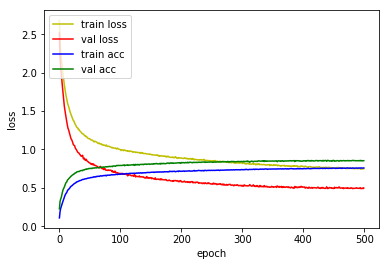

4815/4815 [==============================] - 2s 347us/sample - loss: 0.5601 - acc: 0.8363
Loss: 0.5600777815559324 Accuracy: 0.8363448

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6348 - acc: 0.1261
Epoch 00001: val_loss improved from inf to 2.31960, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/001-2.3196.hdf5
36805/36805 [==============================] - 26s 698us/sample - loss: 2.6347 - acc: 0.1261 - val_loss: 2.3196 - val_acc: 0.2609
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2696 - acc: 0.2257
Epoch 00002: val_loss improved from 2.31960 to 2.01404, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/002-2.0140.hdf5
36805/36805 [==============================] - 24s 650us/sample - loss: 2.2696 - acc: 0.2257 - val_loss: 2.0140 - val_acc: 0.3913
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8735 - acc: 0.7279
Epoch 00022: val_loss improved from 0.58559 to 0.57951, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/022-0.5795.hdf5
36805/36805 [==============================] - 24s 650us/sample - loss: 0.8735 - acc: 0.7279 - val_loss: 0.5795 - val_acc: 0.8334
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8628 - acc: 0.7349
Epoch 00023: val_loss improved from 0.57951 to 0.56685, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/023-0.5669.hdf5
36805/36805 [==============================] - 24s 647us/sample - loss: 0.8628 - acc: 0.7349 - val_loss: 0.5669 - val_acc: 0.8372
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8552 - acc: 0.7344
Epoch 00024: val_loss improved from 0.56685 to 0.54176, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_ch

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6488 - acc: 0.7996
Epoch 00046: val_loss did not improve from 0.40355
36805/36805 [==============================] - 24s 645us/sample - loss: 0.6489 - acc: 0.7996 - val_loss: 0.4113 - val_acc: 0.8786
Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6475 - acc: 0.8009
Epoch 00047: val_loss improved from 0.40355 to 0.38719, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/047-0.3872.hdf5
36805/36805 [==============================] - 24s 644us/sample - loss: 0.6480 - acc: 0.8008 - val_loss: 0.3872 - val_acc: 0.8859
Epoch 48/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6456 - acc: 0.8014
Epoch 00048: val_loss did not improve from 0.38719
36805/36805 [==============================] - 24s 653us/sample - loss: 0.6455 - acc: 0.8014 - val_loss: 0.3881 - val_acc: 0.8908
Epoch 49/500
36800/36805 [============================>.] -

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5700 - acc: 0.8244
Epoch 00071: val_loss did not improve from 0.33360
36805/36805 [==============================] - 24s 647us/sample - loss: 0.5700 - acc: 0.8244 - val_loss: 0.3341 - val_acc: 0.9040
Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5633 - acc: 0.8234
Epoch 00072: val_loss improved from 0.33360 to 0.32785, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/072-0.3279.hdf5
36805/36805 [==============================] - 24s 645us/sample - loss: 0.5632 - acc: 0.8235 - val_loss: 0.3279 - val_acc: 0.9054
Epoch 73/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5556 - acc: 0.8284
Epoch 00073: val_loss did not improve from 0.32785
36805/36805 [==============================] - 24s 647us/sample - loss: 0.5558 - acc: 0.8283 - val_loss: 0.3379 - val_acc: 0.9052
Epoch 74/500
36800/36805 [============================>.] -

Epoch 97/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5100 - acc: 0.8430
Epoch 00097: val_loss did not improve from 0.29791
36805/36805 [==============================] - 24s 646us/sample - loss: 0.5095 - acc: 0.8431 - val_loss: 0.3073 - val_acc: 0.9166
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5037 - acc: 0.8448
Epoch 00098: val_loss improved from 0.29791 to 0.29623, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/098-0.2962.hdf5
36805/36805 [==============================] - 24s 649us/sample - loss: 0.5038 - acc: 0.8448 - val_loss: 0.2962 - val_acc: 0.9180
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5067 - acc: 0.8424
Epoch 00099: val_loss did not improve from 0.29623
36805/36805 [==============================] - 24s 652us/sample - loss: 0.5067 - acc: 0.8424 - val_loss: 0.3004 - val_acc: 0.9171
Epoch 100/500
36736/36805 [============================>.] 

Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4678 - acc: 0.8560
Epoch 00125: val_loss did not improve from 0.28693
36805/36805 [==============================] - 24s 649us/sample - loss: 0.4678 - acc: 0.8560 - val_loss: 0.2936 - val_acc: 0.9178
Epoch 126/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4655 - acc: 0.8545
Epoch 00126: val_loss improved from 0.28693 to 0.28344, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/126-0.2834.hdf5
36805/36805 [==============================] - 24s 650us/sample - loss: 0.4656 - acc: 0.8545 - val_loss: 0.2834 - val_acc: 0.9208
Epoch 127/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4579 - acc: 0.8584
Epoch 00127: val_loss improved from 0.28344 to 0.27930, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv_checkpoint/127-0.2793.hdf5
36805/36805 [==============================] - 24s 645us/sample - loss: 0.4577 

Epoch 153/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4353 - acc: 0.8645
Epoch 00153: val_loss did not improve from 0.27251
36805/36805 [==============================] - 24s 647us/sample - loss: 0.4356 - acc: 0.8644 - val_loss: 0.2731 - val_acc: 0.9227
Epoch 154/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4292 - acc: 0.8671
Epoch 00154: val_loss did not improve from 0.27251
36805/36805 [==============================] - 24s 642us/sample - loss: 0.4291 - acc: 0.8672 - val_loss: 0.2759 - val_acc: 0.9220
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4339 - acc: 0.8665
Epoch 00155: val_loss did not improve from 0.27251
36805/36805 [==============================] - 24s 646us/sample - loss: 0.4338 - acc: 0.8665 - val_loss: 0.2823 - val_acc: 0.9201
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4291 - acc: 0.8649
Epoch 00156: val_loss did not improve from 0.27251
36805/36805 [=

Epoch 181/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4120 - acc: 0.8728
Epoch 00181: val_loss did not improve from 0.26381
36805/36805 [==============================] - 24s 652us/sample - loss: 0.4120 - acc: 0.8728 - val_loss: 0.2840 - val_acc: 0.9189
Epoch 182/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4090 - acc: 0.8729
Epoch 00182: val_loss did not improve from 0.26381
36805/36805 [==============================] - 24s 643us/sample - loss: 0.4090 - acc: 0.8729 - val_loss: 0.2683 - val_acc: 0.9236
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4029 - acc: 0.8753
Epoch 00183: val_loss did not improve from 0.26381
36805/36805 [==============================] - 24s 643us/sample - loss: 0.4029 - acc: 0.8753 - val_loss: 0.2685 - val_acc: 0.9231
Epoch 184/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4091 - acc: 0.8724
Epoch 00184: val_loss did not improve from 0.26381
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.3874 - acc: 0.8793
Epoch 00209: val_loss did not improve from 0.25997
36805/36805 [==============================] - 24s 645us/sample - loss: 0.3875 - acc: 0.8793 - val_loss: 0.2710 - val_acc: 0.9224
Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3917 - acc: 0.8782
Epoch 00210: val_loss did not improve from 0.25997
36805/36805 [==============================] - 24s 642us/sample - loss: 0.3917 - acc: 0.8782 - val_loss: 0.2627 - val_acc: 0.9266
Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3856 - acc: 0.8789
Epoch 00211: val_loss did not improve from 0.25997
36805/36805 [==============================] - 24s 646us/sample - loss: 0.3856 - acc: 0.8790 - val_loss: 0.2688 - val_acc: 0.9266
Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3812 - acc: 0.8803
Epoch 00212: val_loss did not improve from 0.25997
36805/36805 [===============

Epoch 237/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3768 - acc: 0.8831
Epoch 00237: val_loss did not improve from 0.25533
36805/36805 [==============================] - 24s 648us/sample - loss: 0.3767 - acc: 0.8832 - val_loss: 0.2599 - val_acc: 0.9266
Epoch 238/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3674 - acc: 0.8833
Epoch 00238: val_loss did not improve from 0.25533
36805/36805 [==============================] - 24s 644us/sample - loss: 0.3674 - acc: 0.8833 - val_loss: 0.2610 - val_acc: 0.9266
Epoch 239/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3696 - acc: 0.8849
Epoch 00239: val_loss did not improve from 0.25533
36805/36805 [==============================] - 24s 643us/sample - loss: 0.3696 - acc: 0.8849 - val_loss: 0.2689 - val_acc: 0.9234
Epoch 240/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3697 - acc: 0.8843
Epoch 00240: val_loss did not improve from 0.25533
36805/36805 [=

Epoch 266/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3576 - acc: 0.8875
Epoch 00266: val_loss did not improve from 0.25461
36805/36805 [==============================] - 24s 647us/sample - loss: 0.3574 - acc: 0.8875 - val_loss: 0.2630 - val_acc: 0.9278
Epoch 267/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3552 - acc: 0.8871
Epoch 00267: val_loss did not improve from 0.25461
36805/36805 [==============================] - 24s 648us/sample - loss: 0.3552 - acc: 0.8871 - val_loss: 0.2612 - val_acc: 0.9255
Epoch 268/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3555 - acc: 0.8869
Epoch 00268: val_loss did not improve from 0.25461
36805/36805 [==============================] - 24s 647us/sample - loss: 0.3555 - acc: 0.8869 - val_loss: 0.2643 - val_acc: 0.9257
Epoch 269/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3576 - acc: 0.8872
Epoch 00269: val_loss did not improve from 0.25461
36805/36805 [=

Epoch 295/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3433 - acc: 0.8909
Epoch 00295: val_loss did not improve from 0.25263
36805/36805 [==============================] - 24s 643us/sample - loss: 0.3433 - acc: 0.8909 - val_loss: 0.2570 - val_acc: 0.9266
Epoch 296/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3416 - acc: 0.8914
Epoch 00296: val_loss did not improve from 0.25263
36805/36805 [==============================] - 24s 646us/sample - loss: 0.3417 - acc: 0.8913 - val_loss: 0.2559 - val_acc: 0.9271
Epoch 297/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3451 - acc: 0.8905
Epoch 00297: val_loss did not improve from 0.25263
36805/36805 [==============================] - 24s 647us/sample - loss: 0.3451 - acc: 0.8905 - val_loss: 0.2575 - val_acc: 0.9238
Epoch 298/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3441 - acc: 0.8910
Epoch 00298: val_loss did not improve from 0.25263
36805/36805 [=

Epoch 324/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3335 - acc: 0.8933
Epoch 00324: val_loss did not improve from 0.25081
36805/36805 [==============================] - 24s 648us/sample - loss: 0.3338 - acc: 0.8932 - val_loss: 0.2590 - val_acc: 0.9290
Epoch 325/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3289 - acc: 0.8953
Epoch 00325: val_loss did not improve from 0.25081
36805/36805 [==============================] - 24s 645us/sample - loss: 0.3288 - acc: 0.8952 - val_loss: 0.2677 - val_acc: 0.9250
Epoch 326/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3291 - acc: 0.8961
Epoch 00326: val_loss did not improve from 0.25081
36805/36805 [==============================] - 24s 648us/sample - loss: 0.3291 - acc: 0.8962 - val_loss: 0.2593 - val_acc: 0.9252
Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3298 - acc: 0.8953
Epoch 00327: val_loss did not improve from 0.25081
36805/36805 [=

Epoch 354/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3202 - acc: 0.8955
Epoch 00354: val_loss did not improve from 0.25081
36805/36805 [==============================] - 24s 649us/sample - loss: 0.3201 - acc: 0.8955 - val_loss: 0.2613 - val_acc: 0.9262
Epoch 355/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3172 - acc: 0.8985
Epoch 00355: val_loss did not improve from 0.25081
36805/36805 [==============================] - 24s 645us/sample - loss: 0.3174 - acc: 0.8985 - val_loss: 0.2635 - val_acc: 0.9264
Epoch 356/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3207 - acc: 0.8972
Epoch 00356: val_loss did not improve from 0.25081
36805/36805 [==============================] - 24s 649us/sample - loss: 0.3207 - acc: 0.8972 - val_loss: 0.2602 - val_acc: 0.9276
Epoch 357/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3181 - acc: 0.8977
Epoch 00357: val_loss did not improve from 0.25081
36805/36805 [=

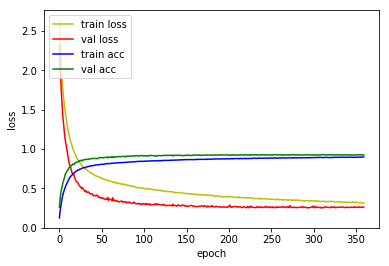

4815/4815 [==============================] - 2s 383us/sample - loss: 0.2973 - acc: 0.9134
Loss: 0.2973256352410757 Accuracy: 0.91339564

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5651 - acc: 0.1544
Epoch 00001: val_loss improved from inf to 2.10545, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/001-2.1054.hdf5
36805/36805 [==============================] - 27s 747us/sample - loss: 2.5651 - acc: 0.1544 - val_loss: 2.1054 - val_acc: 0.3664
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0544 - acc: 0.3169
Epoch 00002: val_loss improved from 2.10545 to 1.67195, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/002-1.6719.hdf5
36805/36805 [==============================] - 25s 677us/sample - loss: 2.0540 - acc: 0.3171 - val_loss: 1.6719 - val_acc: 0.4969
Epoch 3/500
36736/36805 [=========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6018 - acc: 0.8117
Epoch 00022: val_loss did not improve from 0.36929
36805/36805 [==============================] - 25s 676us/sample - loss: 0.6017 - acc: 0.8117 - val_loss: 0.3900 - val_acc: 0.8805
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5910 - acc: 0.8140
Epoch 00023: val_loss improved from 0.36929 to 0.35407, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/023-0.3541.hdf5
36805/36805 [==============================] - 25s 673us/sample - loss: 0.5909 - acc: 0.8140 - val_loss: 0.3541 - val_acc: 0.8945
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5695 - acc: 0.8217
Epoch 00024: val_loss improved from 0.35407 to 0.33741, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/024-0.3374.hdf5
36805/36805 [==============================] - 25s 677us/sample - loss: 0.5696 - a

Epoch 45/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4136 - acc: 0.8690
Epoch 00045: val_loss improved from 0.24282 to 0.23557, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/045-0.2356.hdf5
36805/36805 [==============================] - 25s 680us/sample - loss: 0.4133 - acc: 0.8691 - val_loss: 0.2356 - val_acc: 0.9285
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4061 - acc: 0.8733
Epoch 00046: val_loss did not improve from 0.23557
36805/36805 [==============================] - 25s 679us/sample - loss: 0.4061 - acc: 0.8734 - val_loss: 0.2480 - val_acc: 0.9287
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4036 - acc: 0.8745
Epoch 00047: val_loss improved from 0.23557 to 0.23503, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/047-0.2350.hdf5
36805/36805 [==============================] - 25s 674us/sample - loss: 0.4036 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.3280 - acc: 0.8958
Epoch 00070: val_loss improved from 0.19685 to 0.19647, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_6_conv_checkpoint/070-0.1965.hdf5
36805/36805 [==============================] - 25s 682us/sample - loss: 0.3281 - acc: 0.8958 - val_loss: 0.1965 - val_acc: 0.9392
Epoch 71/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3283 - acc: 0.8956
Epoch 00071: val_loss did not improve from 0.19647
36805/36805 [==============================] - 24s 664us/sample - loss: 0.3280 - acc: 0.8957 - val_loss: 0.2032 - val_acc: 0.9376
Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3246 - acc: 0.8981
Epoch 00072: val_loss did not improve from 0.19647
36805/36805 [==============================] - 25s 677us/sample - loss: 0.3247 - acc: 0.8982 - val_loss: 0.2077 - val_acc: 0.9359
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - lo

36736/36805 [============================>.] - ETA: 0s - loss: 0.2793 - acc: 0.9102
Epoch 00096: val_loss did not improve from 0.17580
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2790 - acc: 0.9103 - val_loss: 0.1833 - val_acc: 0.9434
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2766 - acc: 0.9117
Epoch 00097: val_loss did not improve from 0.17580
36805/36805 [==============================] - 25s 673us/sample - loss: 0.2767 - acc: 0.9116 - val_loss: 0.1811 - val_acc: 0.9455
Epoch 98/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2798 - acc: 0.9100
Epoch 00098: val_loss did not improve from 0.17580
36805/36805 [==============================] - 25s 673us/sample - loss: 0.2799 - acc: 0.9099 - val_loss: 0.2013 - val_acc: 0.9369
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2728 - acc: 0.9144
Epoch 00099: val_loss improved from 0.17580 to 0.17532, saving model to model/chec

36736/36805 [============================>.] - ETA: 0s - loss: 0.2410 - acc: 0.9215
Epoch 00123: val_loss did not improve from 0.16295
36805/36805 [==============================] - 25s 675us/sample - loss: 0.2408 - acc: 0.9216 - val_loss: 0.1670 - val_acc: 0.9460
Epoch 124/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2450 - acc: 0.9207
Epoch 00124: val_loss did not improve from 0.16295
36805/36805 [==============================] - 24s 663us/sample - loss: 0.2449 - acc: 0.9207 - val_loss: 0.1640 - val_acc: 0.9478
Epoch 125/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2451 - acc: 0.9220
Epoch 00125: val_loss did not improve from 0.16295
36805/36805 [==============================] - 25s 675us/sample - loss: 0.2452 - acc: 0.9220 - val_loss: 0.1687 - val_acc: 0.9462
Epoch 126/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2417 - acc: 0.9204
Epoch 00126: val_loss improved from 0.16295 to 0.16124, saving model to model/c

Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2096 - acc: 0.9318
Epoch 00151: val_loss did not improve from 0.15205
36805/36805 [==============================] - 25s 668us/sample - loss: 0.2096 - acc: 0.9318 - val_loss: 0.1533 - val_acc: 0.9509
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2176 - acc: 0.9296
Epoch 00152: val_loss did not improve from 0.15205
36805/36805 [==============================] - 25s 678us/sample - loss: 0.2176 - acc: 0.9296 - val_loss: 0.1538 - val_acc: 0.9502
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2151 - acc: 0.9290
Epoch 00153: val_loss did not improve from 0.15205
36805/36805 [==============================] - 25s 680us/sample - loss: 0.2151 - acc: 0.9291 - val_loss: 0.1604 - val_acc: 0.9469
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9301
Epoch 00154: val_loss did not improve from 0.15205
36805/36805 [=

Epoch 180/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2001 - acc: 0.9350
Epoch 00180: val_loss did not improve from 0.15015
36805/36805 [==============================] - 25s 675us/sample - loss: 0.2002 - acc: 0.9350 - val_loss: 0.1556 - val_acc: 0.9518
Epoch 181/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1946 - acc: 0.9360
Epoch 00181: val_loss did not improve from 0.15015
36805/36805 [==============================] - 24s 662us/sample - loss: 0.1946 - acc: 0.9360 - val_loss: 0.1616 - val_acc: 0.9506
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9363
Epoch 00182: val_loss did not improve from 0.15015
36805/36805 [==============================] - 25s 681us/sample - loss: 0.1941 - acc: 0.9363 - val_loss: 0.1629 - val_acc: 0.9497
Epoch 183/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9349
Epoch 00183: val_loss did not improve from 0.15015
36805/36805 [=

Epoch 210/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1692 - acc: 0.9441
Epoch 00210: val_loss did not improve from 0.15015
36805/36805 [==============================] - 25s 672us/sample - loss: 0.1693 - acc: 0.9441 - val_loss: 0.1726 - val_acc: 0.9497
Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1770 - acc: 0.9417
Epoch 00211: val_loss did not improve from 0.15015
36805/36805 [==============================] - 25s 672us/sample - loss: 0.1770 - acc: 0.9417 - val_loss: 0.1606 - val_acc: 0.9513
Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1794 - acc: 0.9401
Epoch 00212: val_loss did not improve from 0.15015
36805/36805 [==============================] - 25s 667us/sample - loss: 0.1794 - acc: 0.9401 - val_loss: 0.1523 - val_acc: 0.9546
Epoch 213/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1759 - acc: 0.9424
Epoch 00213: val_loss did not improve from 0.15015
36805/36805 [=

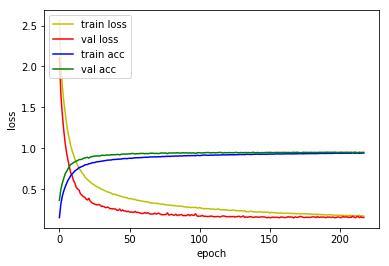

4815/4815 [==============================] - 2s 429us/sample - loss: 0.2019 - acc: 0.9394
Loss: 0.2018641644549147 Accuracy: 0.9393562

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4417 - acc: 0.1912
Epoch 00001: val_loss improved from inf to 1.75846, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv_checkpoint/001-1.7585.hdf5
36805/36805 [==============================] - 30s 807us/sample - loss: 2.4417 - acc: 0.1912 - val_loss: 1.7585 - val_acc: 0.5041
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7344 - acc: 0.4289
Epoch 00002: val_loss improved from 1.75846 to 1.19114, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv_checkpoint/002-1.1911.hdf5
36805/36805 [==============================] - 25s 690us/sample - loss: 1.7345 - acc: 0.4289 - val_loss: 1.1911 - val_acc: 0.6548
Epoch 3/500
36736/36805 [==========================

36736/36805 [============================>.] - ETA: 0s - loss: 0.3498 - acc: 0.8922
Epoch 00022: val_loss improved from 0.18958 to 0.18521, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv_checkpoint/022-0.1852.hdf5
36805/36805 [==============================] - 25s 689us/sample - loss: 0.3496 - acc: 0.8923 - val_loss: 0.1852 - val_acc: 0.9460
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3337 - acc: 0.8968
Epoch 00023: val_loss improved from 0.18521 to 0.18046, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv_checkpoint/023-0.1805.hdf5
36805/36805 [==============================] - 25s 688us/sample - loss: 0.3336 - acc: 0.8968 - val_loss: 0.1805 - val_acc: 0.9483
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3220 - acc: 0.8986
Epoch 00024: val_loss improved from 0.18046 to 0.17769, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv_checkpoint/024-

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2140 - acc: 0.9319
Epoch 00047: val_loss did not improve from 0.13626
36805/36805 [==============================] - 25s 685us/sample - loss: 0.2139 - acc: 0.9319 - val_loss: 0.1384 - val_acc: 0.9599
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2115 - acc: 0.9326
Epoch 00048: val_loss did not improve from 0.13626
36805/36805 [==============================] - 25s 685us/sample - loss: 0.2115 - acc: 0.9326 - val_loss: 0.1368 - val_acc: 0.9578
Epoch 49/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2077 - acc: 0.9339
Epoch 00049: val_loss improved from 0.13626 to 0.12747, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv_checkpoint/049-0.1275.hdf5
36805/36805 [==============================] - 25s 683us/sample - loss: 0.2078 - acc: 0.9339 - val_loss: 0.1275 - val_acc: 0.9613
Epoch 50/500
36736/36805 [============================>.] -

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1609 - acc: 0.9494
Epoch 00073: val_loss did not improve from 0.11558
36805/36805 [==============================] - 25s 690us/sample - loss: 0.1609 - acc: 0.9494 - val_loss: 0.1199 - val_acc: 0.9627
Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9496
Epoch 00074: val_loss did not improve from 0.11558
36805/36805 [==============================] - 25s 690us/sample - loss: 0.1567 - acc: 0.9495 - val_loss: 0.1199 - val_acc: 0.9623
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1585 - acc: 0.9492
Epoch 00075: val_loss did not improve from 0.11558
36805/36805 [==============================] - 25s 676us/sample - loss: 0.1585 - acc: 0.9492 - val_loss: 0.1184 - val_acc: 0.9639
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1551 - acc: 0.9506
Epoch 00076: val_loss did not improve from 0.11558
36805/36805 [=====

Epoch 102/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9594
Epoch 00102: val_loss did not improve from 0.10895
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1254 - acc: 0.9594 - val_loss: 0.1203 - val_acc: 0.9609
Epoch 103/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9599
Epoch 00103: val_loss did not improve from 0.10895
36805/36805 [==============================] - 25s 693us/sample - loss: 0.1204 - acc: 0.9600 - val_loss: 0.1238 - val_acc: 0.9627
Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1234 - acc: 0.9595
Epoch 00104: val_loss did not improve from 0.10895
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1236 - acc: 0.9595 - val_loss: 0.1183 - val_acc: 0.9641
Epoch 105/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9606
Epoch 00105: val_loss did not improve from 0.10895
36805/36805 [=

Epoch 132/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9679
Epoch 00132: val_loss did not improve from 0.10895
36805/36805 [==============================] - 25s 690us/sample - loss: 0.0975 - acc: 0.9679 - val_loss: 0.1182 - val_acc: 0.9646
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9685
Epoch 00133: val_loss did not improve from 0.10895
36805/36805 [==============================] - 25s 684us/sample - loss: 0.0971 - acc: 0.9685 - val_loss: 0.1285 - val_acc: 0.9634

1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv Model


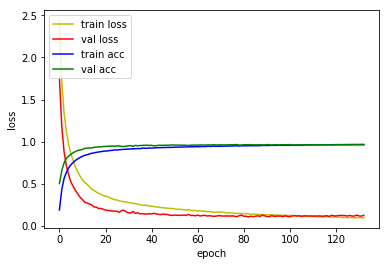

4815/4815 [==============================] - 2s 439us/sample - loss: 0.1657 - acc: 0.9489
Loss: 0.16570895418586637 Accuracy: 0.94890964

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3417 - acc: 0.2352
Epoch 00001: val_loss improved from inf to 1.51866, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_8_conv_checkpoint/001-1.5187.hdf5
36805/36805 [==============================] - 32s 867us/sample - loss: 2.3417 - acc: 0.2352 - val_loss: 1.5187 - val_acc: 0.5577
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4928 - acc: 0.5201
Epoch 00002: val_loss improved from 1.51866 to 1.02238, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_8_conv_checkpoint/002-1.0224.hdf5
36805/36805 [==============================] - 26s 702us/sample - loss: 1.4927 - acc: 0.5201 - val_loss: 1.0224 - val_acc: 0.7051
Epoch 3/500
36800/36805 [========================

Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2756 - acc: 0.9120
Epoch 00023: val_loss improved from 0.18971 to 0.18490, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_8_conv_checkpoint/023-0.1849.hdf5
36805/36805 [==============================] - 26s 715us/sample - loss: 0.2756 - acc: 0.9121 - val_loss: 0.1849 - val_acc: 0.9432
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2706 - acc: 0.9144
Epoch 00024: val_loss improved from 0.18490 to 0.17965, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_8_conv_checkpoint/024-0.1797.hdf5
36805/36805 [==============================] - 26s 702us/sample - loss: 0.2707 - acc: 0.9143 - val_loss: 0.1797 - val_acc: 0.9446
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2629 - acc: 0.9171
Epoch 00025: val_loss improved from 0.17965 to 0.17520, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_8_conv_ch

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1543 - acc: 0.9503
Epoch 00048: val_loss did not improve from 0.13585
36805/36805 [==============================] - 19s 516us/sample - loss: 0.1543 - acc: 0.9503 - val_loss: 0.1377 - val_acc: 0.9560
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1501 - acc: 0.9518
Epoch 00049: val_loss improved from 0.13585 to 0.13330, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_8_conv_checkpoint/049-0.1333.hdf5
36805/36805 [==============================] - 19s 519us/sample - loss: 0.1501 - acc: 0.9518 - val_loss: 0.1333 - val_acc: 0.9592
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1515 - acc: 0.9496
Epoch 00050: val_loss did not improve from 0.13330
36805/36805 [==============================] - 19s 513us/sample - loss: 0.1514 - acc: 0.9497 - val_loss: 0.1361 - val_acc: 0.9597
Epoch 51/500
36800/36805 [============================>.] -

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9679
Epoch 00076: val_loss did not improve from 0.12620
36805/36805 [==============================] - 19s 510us/sample - loss: 0.0960 - acc: 0.9679 - val_loss: 0.1438 - val_acc: 0.9585
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9692
Epoch 00077: val_loss did not improve from 0.12620
36805/36805 [==============================] - 19s 520us/sample - loss: 0.0932 - acc: 0.9692 - val_loss: 0.1324 - val_acc: 0.9634
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9692
Epoch 00078: val_loss did not improve from 0.12620
36805/36805 [==============================] - 19s 514us/sample - loss: 0.0933 - acc: 0.9692 - val_loss: 0.1283 - val_acc: 0.9632
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0919 - acc: 0.9697
Epoch 00079: val_loss did not improve from 0.12620
36805/36805 [=====

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9763
Epoch 00106: val_loss did not improve from 0.12620
36805/36805 [==============================] - 19s 518us/sample - loss: 0.0687 - acc: 0.9763 - val_loss: 0.1554 - val_acc: 0.9602
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9786
Epoch 00107: val_loss did not improve from 0.12620
36805/36805 [==============================] - 19s 520us/sample - loss: 0.0628 - acc: 0.9785 - val_loss: 0.1513 - val_acc: 0.9620
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9793
Epoch 00108: val_loss did not improve from 0.12620
36805/36805 [==============================] - 19s 513us/sample - loss: 0.0615 - acc: 0.9794 - val_loss: 0.1446 - val_acc: 0.9606
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9789
Epoch 00109: val_loss did not improve from 0.12620
36805/36805 [=

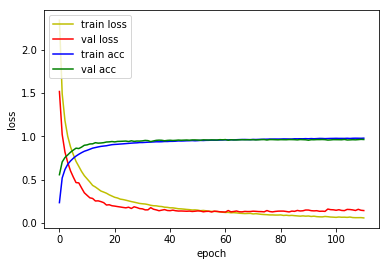

4815/4815 [==============================] - 2s 389us/sample - loss: 0.1822 - acc: 0.9406
Loss: 0.18217745269663238 Accuracy: 0.9406023



In [10]:
base = '1D_CNN_custom_multi_3_GMP_ch_32_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GMP_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 374us/sample - loss: 0.5601 - acc: 0.8363
Loss: 0.5600777815559324 Accuracy: 0.8363448

1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 32)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPoo

4815/4815 [==============================] - 2s 397us/sample - loss: 0.2019 - acc: 0.9394
Loss: 0.2018641644549147 Accuracy: 0.9393562

1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 32)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPoo

4815/4815 [==============================] - 2s 406us/sample - loss: 0.1822 - acc: 0.9406
Loss: 0.18217745269663238 Accuracy: 0.9406023


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_GMP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 412us/sample - loss: 0.5621 - acc: 0.8336
Loss: 0.5620785628461887 Accuracy: 0.83364487

1D_CNN_custom_multi_3_GMP_ch_32_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 32)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPo

4815/4815 [==============================] - 2s 458us/sample - loss: 0.2087 - acc: 0.9383
Loss: 0.20871542110373792 Accuracy: 0.9383178

1D_CNN_custom_multi_3_GMP_ch_32_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 32)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPo

4815/4815 [==============================] - 2s 501us/sample - loss: 0.2041 - acc: 0.9493
Loss: 0.20407272546928326 Accuracy: 0.949325
